## Урок 2. Профилирование пользователей. Сегментация: unsupervised learning (clustering, LDA/ARTM), supervised (multi/binary classification)
1. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке).
2. Повторить п.1, но используя уже не медиану, а max.
3. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score
4. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных.<br/>
Ссылки
http://www.machinelearning.ru/wiki/images/d/d5/Voron17survey-artm.pdf
https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation
Библиотеки, которые нужно установить:<br/>
gensim, razdel, pymorphy2, nltk

In [1]:
import pandas as pd
import itertools
"""
!pip install gensim
!pip install --upgrade razdel
!pip install --upgrade nltk
!pip install pymorphy2
"""

'\n!pip install gensim\n!pip install --upgrade razdel\n!pip install --upgrade nltk\n!pip install pymorphy2\n'

Наши новости

In [2]:
news = pd.read_csv("articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


Загрузим пользователей и списки последних прочитанных новостей

In [3]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


Итак, нам нужно получить векторные представления пользователей на основе прочитанным ими новостей и самих новостей

### 1. Получаем векторные представления новостей

In [4]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
#from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

C:\ProgramData\Anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [6]:
#предобработка текстов
import re
import numpy as np
from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel
#!pip install razdel

import pymorphy2  # pip install pymorphy2

In [7]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [8]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [9]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [10]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

<ipython-input-9-7ee348d9b386>:15: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)


Wall time: 31 s


In [11]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

Wall time: 4min 22s


А теперь в 3 строчки обучим нашу модель

In [12]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Что такое common_dictionary и как он выглядит

In [13]:
common_dictionary[10]

'ватутин'

Все просто - это словарь наших слов

Запускаем обучение

In [14]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

Wall time: 42.1 s


In [15]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [16]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'свой', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'провести', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'работа', 'сказать', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'мочь', 'играть', 'ещё', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'это', 'хороший']


[(0, 0.23943816), (12, 0.027043056), (15, 0.7139227)]

In [17]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: сигнал энергия звезда запланировать увидеть открыться цвет
topic_1: журнал поверхность мышь оборудование городской музыка снежный
topic_2: год млн цена составить рост общий топливо
topic_3: экипаж убийство следователь флот место пилот характерный
topic_4: рак восток испытание су ким внедрение сбить
topic_5: научный продукция активность доклад кровь кость необычный
topic_6: взрыв корея южный таиланд выбросить лестница япония
topic_7: млрд китай китайский японский индия япония белоруссия
topic_8: nn год сайт обращение стать градус узнать
topic_9: это который год россия мочь свой также
topic_10: смерть двигатель британский больной умереть инженер лондон
topic_11: памятник берег конструкция оборудование модернизация проверять сосед
topic_12: гражданин исследование ребёнок болезнь лаборатория фронт народный
topic_13: фонд тело операция обнаружить найти жертва приложение
topic_14: товар штат связанный отчёт параметр польша статья
topic_15: это эксперимент сотрудник чиновник проверка

Очень неплохо - большинство тем вполне можно описать о чем они

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [18]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [19]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.059255,...,0.000000,0.492818,0.000000,0.0,0.000000,0.374540,0.0,0.0,0.000000,0.025320
1,4896,0.256293,0.0,0.0,0.0,0.0,0.000000,0.226789,0.0,0.000000,...,0.404334,0.091571,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
2,4897,0.239398,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.713968,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
3,4898,0.166025,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.218227,0.000000,0.071957,0.0,0.073127,0.000000,0.0,0.0,0.124276,0.235392
4,4899,0.000000,0.0,0.0,0.0,0.0,0.100407,0.000000,0.0,0.057191,...,0.000000,0.000000,0.000000,0.0,0.000000,0.421946,0.0,0.0,0.000000,0.000000


Прекрасно, мы получили вектора наших новостей! И даже умеем интерпретировать получившиеся темы.

Можно двигаться далее

### Следующий шаг - векторные представления пользователей

In [20]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [21]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [22]:
doc_dict[293622]

array([0.        , 0.        , 0.04777969, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.08126549, 0.18500793,
       0.        , 0.        , 0.05076374, 0.        , 0.02460802,
       0.02066694, 0.19652149, 0.        , 0.        , 0.03706034,
       0.        , 0.03592429, 0.        , 0.1471598 , 0.1647315 ])

In [23]:
user_articles_list_mean = users['articles'].iloc[33]
user_articles_list_median = users['articles'].iloc[33]
user_articles_list_max = users['articles'].iloc[33]

def get_user_embedding_mean(user_articles_list_mean):
    user_articles_list_mean = eval(user_articles_list_mean)
    user_vector_mean = np.array([doc_dict[doc_id] for doc_id in user_articles_list_mean])
    user_vector_mean = np.mean(user_vector_mean, 0)
    return user_vector_mean

def get_user_embedding_median(user_articles_list_median):
    user_articles_list_median = eval(user_articles_list_median)
    user_vector_median = np.array([doc_dict[doc_id] for doc_id in user_articles_list_median])
    user_vector_median = np.median(user_vector_median, 0)
    return user_vector_median

def get_user_embedding_max(user_articles_list_max):
    user_articles_list_max = eval(user_articles_list_max)
    user_vector_max = np.array([doc_dict[doc_id] for doc_id in user_articles_list_max])
    user_vector_max = np.max(user_vector_max, 0)
    return user_vector_max

In [24]:
get_user_embedding_mean(user_articles_list_mean)

array([0.00180135, 0.        , 0.00216538, 0.02250448, 0.        ,
       0.00708103, 0.        , 0.        , 0.00872168, 0.32087057,
       0.00239385, 0.        , 0.00374512, 0.        , 0.03510813,
       0.02732789, 0.27513325, 0.05105991, 0.        , 0.02471095,
       0.01943379, 0.07730869, 0.03224773, 0.02664149, 0.04812188])

In [25]:
get_user_embedding_median(user_articles_list_median)

array([0.        , 0.        , 0.        , 0.00926432, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.30668117,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.01254524, 0.23599924, 0.03814359, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.03659262])

In [26]:
get_user_embedding_max(user_articles_list_max)

array([0.01080808, 0.        , 0.01299227, 0.08161649, 0.        ,
       0.04248618, 0.        , 0.        , 0.05233009, 0.61004728,
       0.01436307, 0.        , 0.02247072, 0.        , 0.16246454,
       0.09970542, 0.50080746, 0.13090257, 0.        , 0.14826569,
       0.0992163 , 0.37296107, 0.16243401, 0.15984891, 0.15245995])

Интересовался новостями с топиками topic_3, topic_14 (что-то про политику и государство)

In [27]:
#users['articles'].iloc[33]

In [28]:
#" ".join(news[news['doc_id']==323186]['title'].iloc[0])

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [29]:
user_embeddings_mean = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_mean(x), 1)])
user_embeddings_mean.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings_mean['uid'] = users['uid'].values
user_embeddings_mean = user_embeddings_mean[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings_mean.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.033102,0.0,0.031536,0.001881,0.0,0.000000,0.00335,0.003125,0.065463,...,0.029418,0.128870,0.065127,0.0,0.020432,0.005555,0.095380,0.114501,0.024527,0.035105
1,u108690,0.005549,0.0,0.029872,0.003140,0.0,0.016983,0.00000,0.005091,0.006334,...,0.080782,0.230228,0.048585,0.0,0.020002,0.002058,0.050018,0.020869,0.054438,0.080019
2,u108339,0.001897,0.0,0.009977,0.025496,0.0,0.018945,0.00000,0.000000,0.005802,...,0.053038,0.266137,0.031392,0.0,0.037427,0.001690,0.141790,0.121096,0.010886,0.035683


In [30]:
user_embeddings_median = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_median(x), 1)])
user_embeddings_median.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings_median['uid'] = users['uid'].values
user_embeddings_median = user_embeddings_median[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings_median.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.011286,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.058689,...,0.010333,0.154572,0.000000,0.0,0.000000,0.0,0.123463,0.000000,0.000000,0.000000
1,u108690,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,0.077875,0.238035,0.051937,0.0,0.012929,0.0,0.053534,0.028311,0.021748,0.087628
2,u108339,0.000000,0.0,0.006517,0.025171,0.0,0.016693,0.0,0.0,0.000000,...,0.045543,0.275349,0.011672,0.0,0.022159,0.0,0.119752,0.045589,0.000000,0.020429


In [31]:
user_embeddings_max = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_max(x), 1)])
user_embeddings_max.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings_max['uid'] = users['uid'].values
user_embeddings_max = user_embeddings_max[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings_max.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.149502,0.0,0.141439,0.011285,0.0,0.000000,0.0201,0.018751,0.169690,...,0.127050,0.267554,0.317303,0.0,0.085532,0.033332,0.153068,0.618490,0.147160,0.164732
1,u108690,0.033293,0.0,0.105492,0.018840,0.0,0.061209,0.0000,0.030544,0.020205,...,0.166336,0.363829,0.106803,0.0,0.076376,0.012350,0.068027,0.035282,0.145977,0.140139
2,u108339,0.011381,0.0,0.027768,0.065175,0.0,0.031557,0.0000,0.000000,0.021973,...,0.123029,0.470828,0.086294,0.0,0.123824,0.010138,0.317928,0.349580,0.048190,0.092143


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [32]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [33]:
X_mean = pd.merge(user_embeddings_mean, target, 'left')
X_mean.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.033102,0.0,0.031536,0.001881,0.0,0.000000,0.00335,0.003125,0.065463,...,0.128870,0.065127,0.0,0.020432,0.005555,0.095380,0.114501,0.024527,0.035105,0
1,u108690,0.005549,0.0,0.029872,0.003140,0.0,0.016983,0.00000,0.005091,0.006334,...,0.230228,0.048585,0.0,0.020002,0.002058,0.050018,0.020869,0.054438,0.080019,1
2,u108339,0.001897,0.0,0.009977,0.025496,0.0,0.018945,0.00000,0.000000,0.005802,...,0.266137,0.031392,0.0,0.037427,0.001690,0.141790,0.121096,0.010886,0.035683,1


In [34]:
X_median = pd.merge(user_embeddings_median, target, 'left')
X_median.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.011286,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.058689,...,0.154572,0.000000,0.0,0.000000,0.0,0.123463,0.000000,0.000000,0.000000,0
1,u108690,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,0.238035,0.051937,0.0,0.012929,0.0,0.053534,0.028311,0.021748,0.087628,1
2,u108339,0.000000,0.0,0.006517,0.025171,0.0,0.016693,0.0,0.0,0.000000,...,0.275349,0.011672,0.0,0.022159,0.0,0.119752,0.045589,0.000000,0.020429,1


In [35]:
X_max = pd.merge(user_embeddings_max, target, 'left')
X_max.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.149502,0.0,0.141439,0.011285,0.0,0.000000,0.0201,0.018751,0.169690,...,0.267554,0.317303,0.0,0.085532,0.033332,0.153068,0.618490,0.147160,0.164732,0
1,u108690,0.033293,0.0,0.105492,0.018840,0.0,0.061209,0.0000,0.030544,0.020205,...,0.363829,0.106803,0.0,0.076376,0.012350,0.068027,0.035282,0.145977,0.140139,1
2,u108339,0.011381,0.0,0.027768,0.065175,0.0,0.031557,0.0000,0.000000,0.021973,...,0.470828,0.086294,0.0,0.123824,0.010138,0.317928,0.349580,0.048190,0.092143,1


In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

%matplotlib inline

In [37]:
#разделим данные на train/test
X_mean_train, X_mean_test, y_mean_train, y_mean_test = train_test_split(X_mean[['topic_{}'.format(i) for i in range(25)]], 
                                                    X_mean['churn'], random_state=0)

In [38]:
#разделим данные на train/test
X_median_train, X_median_test, y_median_train, y_median_test = train_test_split(X_median[['topic_{}'.format(i) for i in range(25)]], 
                                                    X_median['churn'], random_state=0)

In [39]:
#разделим данные на train/test
X_max_train, X_max_test, y_max_train, y_max_test = train_test_split(X_max[['topic_{}'.format(i) for i in range(25)]], 
                                                    X_max['churn'], random_state=0)

In [40]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_mean_train, y_mean_train)
logreg.fit(X_median_train, y_median_train)
logreg.fit(X_max_train, y_max_train)

LogisticRegression()

In [41]:
#наши прогнозы для тестовой выборки
preds_mean = logreg.predict_proba(X_mean_test)[:, 1]
preds_mean[:10]

array([0.93711133, 0.96727958, 0.98448694, 0.93361086, 0.93124201,
       0.92243851, 0.9575754 , 0.96584708, 0.9558099 , 0.9430156 ])

In [42]:
preds_median = logreg.predict_proba(X_median_test)[:, 1]
preds_median[:10]

array([0.94379431, 0.99703361, 0.99014707, 0.95458747, 0.95270223,
       0.97797406, 0.98857807, 0.99652241, 0.99006688, 0.95695174])

In [43]:
preds_max = logreg.predict_proba(X_max_test)[:, 1]
preds_max[:10]

array([0.10252924, 0.00097765, 0.61090627, 0.09547932, 0.02226324,
       0.00492925, 0.01188494, 0.00183522, 0.01861996, 0.04419293])

In [44]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

### Рассчитаем Precision, Recall, F_score

In [45]:
precision_mean, recall_mean, thresholds_mean = precision_recall_curve(y_mean_test, preds_mean)
fscore_mean = (2 * precision_mean * recall_mean) / (precision_mean + recall_mean)
# locate the index of the largest f score
ix = np.argmax(fscore_mean)
print('Best Threshold_mean=%f, F-Score_mean=%.3f, Precision_mean=%.3f, Recall_mean=%.3f' % (thresholds_mean[ix], 
                                                                        fscore_mean[ix],
                                                                        precision_mean[ix],
                                                                        recall_mean[ix]))

Best Threshold_mean=0.994300, F-Score_mean=nan, Precision_mean=0.000, Recall_mean=0.000


<ipython-input-45-5d17b9cf3000>:2: RuntimeWarning: invalid value encountered in true_divide
  fscore_mean = (2 * precision_mean * recall_mean) / (precision_mean + recall_mean)


In [46]:
precision_median, recall_median, thresholds_median = precision_recall_curve(y_median_test, preds_median)
fscore_median = (2 * precision_median * recall_median) / (precision_median + recall_median)
# locate the index of the largest f score
ix = np.argmax(fscore_median)
print('Best Threshold_median=%f, F-Score_median=%.3f, Precision_median=%.3f, Recall_median=%.3f' % (thresholds_median[ix], 
                                                                        fscore_median[ix],
                                                                        precision_median[ix],
                                                                        recall_median[ix]))

Best Threshold_median=0.997241, F-Score_median=nan, Precision_median=0.000, Recall_median=0.000


<ipython-input-46-50d055a6dfcf>:2: RuntimeWarning: invalid value encountered in true_divide
  fscore_median = (2 * precision_median * recall_median) / (precision_median + recall_median)


In [47]:
precision_max, recall_max, thresholds_max = precision_recall_curve(y_max_test, preds_max)
fscore_max = (2 * precision_max * recall_max) / (precision_max + recall_max)
# locate the index of the largest f score
ix = np.argmax(fscore_max)
print('Best Threshold_max=%f, F-Score_max=%.3f, Precision_max=%.3f, Recall_max=%.3f' % (thresholds_max[ix], 
                                                                        fscore_max[ix],
                                                                        precision_max[ix],
                                                                        recall_max[ix]))

Best Threshold_max=0.357217, F-Score_max=0.738, Precision_max=0.764, Recall_max=0.714


In [48]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1029  726]
 [  12  233]]


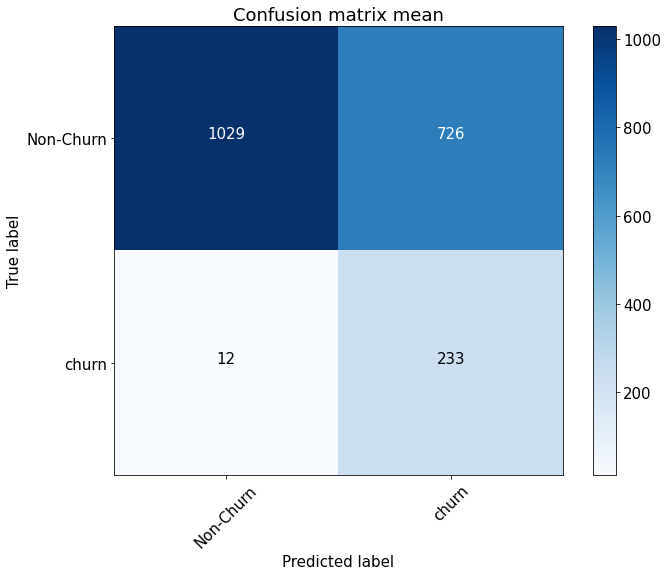

In [49]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_mean_test, preds_mean>thresholds_mean[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix mean')
plt.savefig("conf_matrix.png")
plt.show()

Confusion matrix, without normalization
[[795 960]
 [ 68 177]]


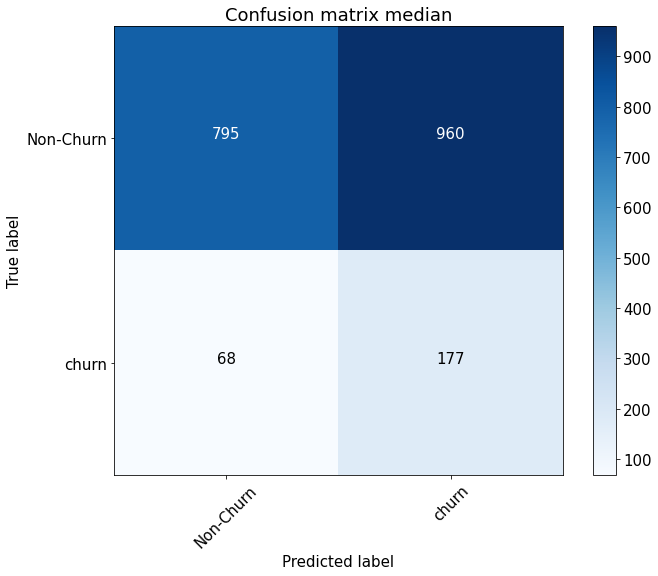

In [50]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_median_test, preds_median>thresholds_median[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix median')
plt.savefig("conf_matrix.png")
plt.show()

Confusion matrix, without normalization
[[1701   54]
 [  71  174]]


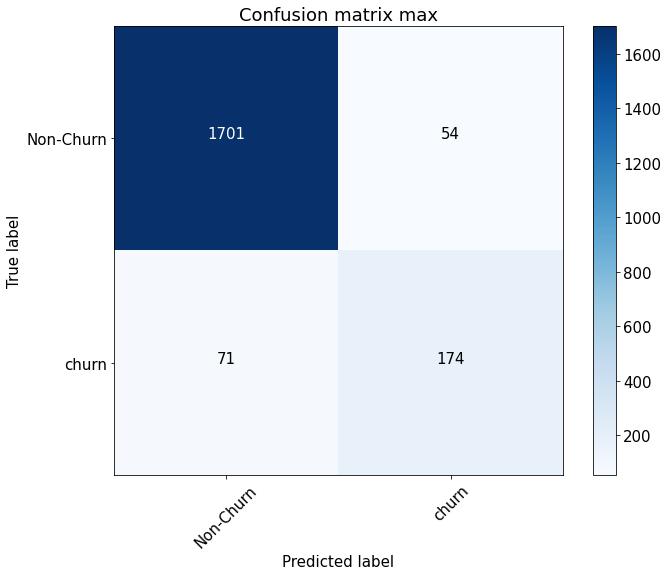

In [51]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_max_test, preds_max>thresholds_max[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix max')
plt.savefig("conf_matrix.png")
plt.show()

In [52]:
roc_auc_mean = roc_auc_score(y_mean_test, preds_mean)
roc_auc_median = roc_auc_score(y_median_test, preds_median)
roc_auc_max = roc_auc_score(y_max_test, preds_max)
print(f'roc_auc_mean:\t{roc_auc_mean}\nroc_auc_median:\t{roc_auc_median}\nroc_auc_max:\t{roc_auc_max}')

roc_auc_mean:	0.869464503750218
roc_auc_median:	0.5508831908831908
roc_auc_max:	0.960653526367812


In [53]:
metrics = [[fscore_mean[ix],precision_mean[ix],recall_mean[ix],roc_auc_mean],
           [fscore_median[ix],precision_median[ix],recall_median[ix],roc_auc_median],
           [fscore_max[ix],precision_max[ix],recall_max[ix],roc_auc_max]]


metrics_comparison_df = pd.DataFrame(np.array(metrics),
                   columns=['fscore', 'precision', 'recall', 'roc_auc'],
                   index=['preds_embeddings_mean', 'preds_embeddings_median', 'preds_embeddings_max'])
metrics_comparison_df

,fscore,precision,recall,roc_auc
preds_embeddings_mean,0.386722,0.242708,0.951020,0.869465
preds_embeddings_median,0.255965,0.155536,0.722449,0.550883
preds_embeddings_max,0.738397,0.764192,0.714286,0.960654
